In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device = }\n")

cifar10_train = CIFAR10(root='../data', train=True)
cifar10_test  = CIFAR10(root='../data', train=False)

X = cifar10_train.data.transpose(0,3,1,2)
X = torch.FloatTensor(X) / 255
y = torch.tensor(cifar10_train.targets)

X_test = cifar10_test.data.transpose(0,3,1,2)
X_test = torch.FloatTensor(X_test) / 255
y_test = torch.tensor(cifar10_test.targets)

labels = cifar10_train.classes

class SemiSupervisedDataset(Dataset):
    def __init__(self, X, y, random_state=42):
        self.X = X
        self.y = y

        supervised_idx, unsupervised_idx = train_test_split(torch.arange(0,len(X)),
                                                            train_size=.6,
                                                            stratify=y,
                                                            random_state=random_state)
        self.supervised_idx = supervised_idx
        self.unsupervised_idx = unsupervised_idx
    
    @property
    def labels(self):
        y = self.y
        y[self.unsupervised_idx] = -1
        return y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx] if idx in self.supervised_idx else torch.tensor(-1)
        return x, y

device = 'cuda'



In [22]:
semisupervised_dataset = SemiSupervisedDataset(X=X, y=y)
semisupervised_dataset

In [23]:
model = resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(labels))

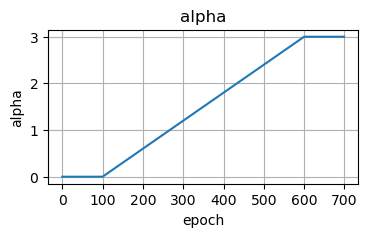

In [24]:
def _alpha(t, alpha_range=(0,3), t_range=(100,600)):
    a = (alpha_range[1] - alpha_range[0]) / (t_range[1] - t_range[0])
    b = -t_range[0] * a

    alpha = a * t + b
    if alpha < alpha_range[0]:
        alpha = alpha_range[0]
    elif alpha > alpha_range[1]:
        alpha = alpha_range[1]
    return alpha


plt.figure(figsize=(4,2))
plt.title('alpha')
plt.plot([_alpha(t) for t in range(700)])
plt.xticks(range(0, 800, 100))
plt.xlabel('epoch')
plt.ylabel('alpha')
plt.grid()
plt.show()

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
alpha     = lambda t: _alpha(t, alpha_range=(0,.4), t_range=(30,60))

transform = T.Compose([
    T.Normalize([.5,.5,.5], [.5,.5,.5])
])

model.to(device)
model.train()

history = []

for e in range(100):
    running_loss = 0
    for i, (X, y) in enumerate(DataLoader(semisupervised_dataset, batch_size=128, shuffle=True)):
        optimizer.zero_grad()

        X = X.to(device)
        y_hat = model(X)
        y_hat = y_hat.cpu()

        labeled = y >= 0

        loss_labeled   = criterion(y_hat[ labeled], y[labeled])
        loss_unlabeled = criterion(y_hat[~labeled], y_hat[~labeled].argmax(1))

        loss = loss_labeled + alpha(e)*loss_unlabeled

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"[epoch {e+1:>3}.{i+1:0>3}][alpha {alpha(e):.3f}] {train_loss):.5f}", end='\r')
    print()

    train_loss = running_loss / (i+1)
    history.append({'alpha': alpha(e), 'loss': loss.item()})


[epoch   1.391][alpha 0.000] 1.89278
[epoch   2.391][alpha 0.000] 1.40858
[epoch   3.391][alpha 0.000] 1.18612
[epoch   4.391][alpha 0.000] 1.01202
[epoch   5.391][alpha 0.000] 0.88953
[epoch   6.391][alpha 0.000] 0.77947
[epoch   7.391][alpha 0.000] 0.67211
[epoch   8.391][alpha 0.000] 0.57245
[epoch   9.391][alpha 0.000] 0.48957
[epoch  10.391][alpha 0.000] 0.40312
[epoch  11.391][alpha 0.000] 0.32144
[epoch  12.391][alpha 0.000] 0.27173
[epoch  13.391][alpha 0.000] 0.21391
[epoch  14.391][alpha 0.000] 0.19120
[epoch  15.391][alpha 0.000] 0.15883
[epoch  16.391][alpha 0.000] 0.14712
[epoch  17.391][alpha 0.000] 0.13467
[epoch  18.391][alpha 0.000] 0.11326
[epoch  19.391][alpha 0.000] 0.10491
[epoch  20.391][alpha 0.000] 0.10037
[epoch  21.391][alpha 0.000] 0.09330
[epoch  22.391][alpha 0.000] 0.07656
[epoch  23.391][alpha 0.000] 0.08893
[epoch  24.391][alpha 0.000] 0.07494
[epoch  25.391][alpha 0.000] 0.08354
[epoch  26.391][alpha 0.000] 0.06883
[epoch  27.391][alpha 0.000] 0.06398
[

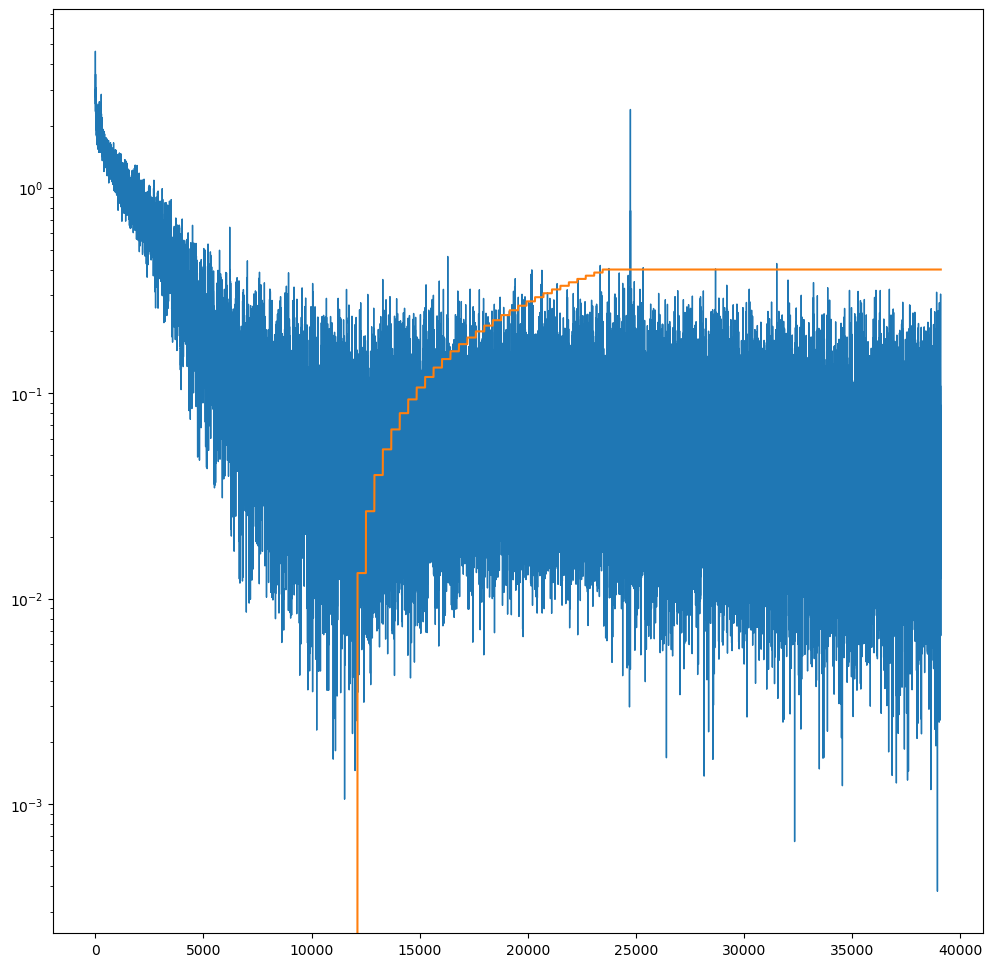

In [32]:
plt.figure(figsize=(12, 12))
plt.plot([h['loss'].item() for h in history], lw=1)
plt.yscale('log')
plt.plot([h['alpha'] for h in history])